In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Data loading, the full dataset from Retailrocket has been added to the dataset folder on the main root of the project's codebase.
BASE_DIR = '/content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project'
df_events = pd.read_csv(f'{BASE_DIR}/dataset/events.csv')
df_categories = pd.read_csv(f'{BASE_DIR}/dataset/category_tree.csv')

In [4]:
df_properties = pd.concat([pd.read_csv(f'{BASE_DIR}/dataset/item_properties_part1.csv'), pd.read_csv(f'{BASE_DIR}/dataset/item_properties_part2.csv')])

In [5]:
# The missing data in each table. It's important to identify these gaps early on.

def missing_values_summary(df, df_name):
    """Calculates and prints the missing values count and percentage for a DataFrame."""
    print(f"# Missing Values in {df_name}")
    missing_count = df.isnull().sum()
    missing_percentage = (missing_count / len(df)) * 100
    missing_df = pd.DataFrame({'Count': missing_count, 'Percentage': missing_percentage})
    print(missing_df[missing_df['Count'] > 0])
    print("\n")

missing_values_summary(df_events, 'df_events')
missing_values_summary(df_properties, 'df_properties')
missing_values_summary(df_categories, 'df_categories')

# Calculate and print unique counts from the events data
unique_visitors = df_events['visitorid'].nunique()
unique_items = df_events['itemid'].nunique()
unique_transactions = df_events['transactionid'].nunique()

print("# Unique Counts in df_events")
print(f"Number of unique visitors: {unique_visitors:,}")
print(f"Number of unique items involved in events: {unique_items:,}")
print(f"Number of unique transactions: {unique_transactions:,}")

# Missing Values in df_events
                 Count  Percentage
transactionid  2733644    99.18519


# Missing Values in df_properties
Empty DataFrame
Columns: [Count, Percentage]
Index: []


# Missing Values in df_categories
          Count  Percentage
parentid     25    1.497903


# Unique Counts in df_events
Number of unique visitors: 1,407,580
Number of unique items involved in events: 235,061
Number of unique transactions: 17,672


### Handling missing values

Our primary goal in this preprocessing step is not to simply drop missing data, but to understand why it's missing and handle it intelligently to preserve our valuable behavioral data.

In [6]:
print("Starting missing value handling...")

# 1. Handling df_events
# EDA showed 99.18% of 'transactionid' are NaN.
# This is expected. The 'transactionid' field is ONLY populated for the 'transaction' event type.
# The 99% of missing values represent all the 'view' and 'addtocart' events.
#
# We MUST NOT drop these rows. Dropping them would remove all our behavioral data
# for non-buying sessions, making it impossible to perform our behavioral clustering.
#
# Action:
# We will fill the NaN values with 0. This makes the column a clean integer type,
# which is easier for processing, and clearly separates non-transaction events (0) from
# actual transaction events (which have a positive ID).
original_event_count = len(df_events)
df_events['transactionid'] = df_events['transactionid'].fillna(0).astype(int)
print(f"Processed 'df_events'. 'transactionid' NaNs filled with 0.")
print(f"Row count remains {len(df_events)} (no rows dropped).")

# 2. Handling df_properties
# EDA showed 0 missing values.
# The data is clean.
# No action required.
print("\nProcessed 'df_properties'. No missing values found.")

# 3. Handling df_categories
# EDA showed 25 missing values for 'parentid'.
# This is also expected. These 25 rows are the "root" categories
# (e.g., "Electronics"). They do not have a parent, so the field is correctly left blank.
#
# We MUST NOT drop these rows, as that would break our category hierarchy.
#
# We will fill these NaNs with 0 to signify
# they are the top-level root nodes. This maintains the integrity of the tree structure.
original_category_count = len(df_categories)
df_categories['parentid'] = df_categories['parentid'].fillna(0).astype(int)
print(f"\nProcessed 'df_categories'. 'parentid' NaNs filled with 0 to represent root categories.")
print(f"Row count remains {len(df_categories)} (no rows dropped).")

print("\nMissing value handling complete.")

Starting missing value handling...
Processed 'df_events'. 'transactionid' NaNs filled with 0.
Row count remains 2756101 (no rows dropped).

Processed 'df_properties'. No missing values found.

Processed 'df_categories'. 'parentid' NaNs filled with 0 to represent root categories.
Row count remains 1669 (no rows dropped).

Missing value handling complete.


### Noise Handling

1. Statistical Noise (Outliers): We saw sessions with 7,000+ events and 50% of visitors with only 1 event. These extremes can pull the cluster centers.

2. Methodological Noise (Irrelevant Data): Sessions without a 'transaction' are essential data for clustering.

**Our Strategy**: We must remove these statistical outliers before we do anything else (like sessionization) because they will severely skew the feature calculations for our K-Means clustering.

In [7]:
# Step 1: Noise Handling (Statistical Outliers)

print(f"Original df_events shape: {df_events.shape}")

# 1. Identify Outlier Visitors
print("Calculating events per visitor...")
events_per_visitor = df_events.groupby('visitorid')['event'].count()

# The EDA showed a massive skew. We'll define 'noise' as the extreme outliers.
# We can find this threshold programmatically by using a
# high quantile. Let's use the 99.9th percentile as our cutoff.
outlier_threshold = events_per_visitor.quantile(0.999)
print(f"Outlier threshold (99.9th percentile) = {outlier_threshold} events")

# Get the list of visitorids that are above this threshold
outlier_visitors = events_per_visitor[events_per_visitor > outlier_threshold].index
print(f"Found {len(outlier_visitors)} outlier visitors.")


# 2. Filter Outlier Events

# Now, we remove all events associated with these outlier
# visitors from our main df_events dataframe. This ensures they
# won't impact our sessionization or feature engineering.
df_events_cleaned = df_events[~df_events['visitorid'].isin(outlier_visitors)].copy()


# 3. Report Results
original_events = len(df_events)
cleaned_events = len(df_events_cleaned)
events_removed = original_events - cleaned_events
percent_removed = (events_removed / original_events) * 100

print("\n# Noise Handling Summary")
print(f"Original total events: {original_events:,}")
print(f"Cleaned total events: {cleaned_events:,}")
print(f"Removed {events_removed:,} events ({percent_removed:.2f}%) belonging to {len(outlier_visitors)} visitors.")
print(f"Cleaned df_events_cleaned shape: {df_events_cleaned.shape}")

# REASONING: This cleaned dataframe is what we'll use for the next step.
# We'll re-assign df_events to this cleaned version for the rest of the pipeline.
df_events = df_events_cleaned

Original df_events shape: (2756101, 5)
Calculating events per visitor...
Outlier threshold (99.9th percentile) = 47.0 events
Found 1352 outlier visitors.

# Noise Handling Summary
Original total events: 2,756,101
Cleaned total events: 2,536,174
Removed 219,927 events (7.98%) belonging to 1352 visitors.
Cleaned df_events_cleaned shape: (2536174, 5)


### Summary

I chose Removal/Filtering because the data identified as "noise" was not just "extreme" data; it was anomalous data.

- Based on the EDAs, the median visitor had only 1 event, while the top 0.1% had over 32, with a max of 7,757.

Why I removed them instead of using other methods:

- They Aren't "Extreme Users," They're "Non-Users." A visitor with thousands of events is almost certainly a bot, scraper, or internal test account. This isn't just an "enthusiastic shopper"; it's a different category of user entirely. Our goal is to cluster real customer behavior, so these non-human actors must be removed.

Why Other Methods Don't Fit:

- Winsorizing (Capping): This technique is for limiting the influence of a single feature (e.g., capping a session duration at 3 hours). It doesn't make sense for a user. We can't "cap" a bot's behavior to make it look like a human—its entire pattern is wrong.

- Imputation/Replacement: These methods are for missing data, not bad data. We have no value to "impute" here.

- Data Smoothing: This is typically for time-series data to reduce signal jitter, which doesn't apply to our task of identifying outlier visitors.

In short: These visitors are removed because they are not part of the population we want to analyze. Their behavior is statistical "noise" that would contaminate our clusters, pulling the cluster centers away from the real, typical user groups we are trying to find.

## Making visitor sessions

In [8]:

print(f"Starting sessionization on {len(df_events):,} events...")

# 1. Convert Timestamp
# To calculate time differences, we must ensure the 'timestamp'
# column is in datetime format.
if not pd.api.types.is_datetime64_any_dtype(df_events['timestamp']):
    print("Converting timestamp from int (milliseconds) to datetime...")
    df_events['timestamp_dt'] = pd.to_datetime(df_events['timestamp'], unit='ms')
else:
    # Handle case where it might have been converted in a notebook
    df_events['timestamp_dt'] = pd.to_datetime(df_events['timestamp'])


# 2. Sort Values
# Sorting by visitor and time is CRITICAL. This ensures
# that events for the same user are sequential before we calculate
# the time difference between their actions.
print("Sorting events by visitorid and timestamp...")
df_events.sort_values(by=['visitorid', 'timestamp_dt'], inplace=True)


# 3. Calculate Time Difference
# We define a session as a period of activity ending with
# 30 minutes (1800 seconds) of inactivity.
session_timeout_seconds = 30 * 60

# We use groupby('visitorid').diff() to calculate the time (in seconds)
# between consecutive events *for the same visitor*.
# The first event for any visitor will result in 'NaT' (Not a Time).
print("Calculating time difference between events for each visitor...")
df_events['time_diff_seconds'] = df_events.groupby('visitorid')['timestamp_dt'].diff().dt.total_seconds()


# 4. Identify New Sessions
# A new session starts when the time_diff is > our timeout,
# OR when it's the very first event for that user (where time_diff is NaN/NaT).
# We create a boolean flag 'new_session_flag' for this.
df_events['new_session_flag'] = (df_events['time_diff_seconds'] > session_timeout_seconds) | (df_events['time_diff_seconds'].isnull())


# 5. Assign Session IDs
# We use cumsum() (cumulative sum) on the 'new_session_flag'
# boolean (where True=1, False=0). This creates a unique, incrementing ID
# for each new session within that visitor's group.
print("Assigning unique session IDs...")
df_events['session_increment_id'] = df_events.groupby('visitorid')['new_session_flag'].cumsum()

# Create a globally unique session_id by combining the visitorid
# (as a string) with the session_increment_id. This will be our
# primary key for the new session-feature matrix.
df_events['session_id'] = df_events['visitorid'].astype(str) + '_' + df_events['session_increment_id'].astype(str)


# 6. Report Results
session_count = df_events['session_id'].nunique()
visitor_count = df_events['visitorid'].nunique()
avg_sessions_per_visitor = session_count / visitor_count
avg_events_per_session = len(df_events) / session_count

print("\n--- Sessionization Summary ---")
print(f"Total events processed: {len(df_events):,}")
print(f"Total unique visitors: {visitor_count:,}")
print(f"Total unique sessions created: {session_count:,}")
print(f"Average sessions per visitor: {avg_sessions_per_visitor:.2f}")
print(f"Average events per session: {avg_events_per_session:.2f}")

# Display a sample of the sessionized data to verify
print("\nSample of sessionized data (showing new session flags):")
display(df_events[['timestamp_dt', 'visitorid', 'event', 'time_diff_seconds', 'new_session_flag', 'session_id']].head(10))

# Clean up intermediate columns before next step
df_events.drop(columns=['time_diff_seconds', 'new_session_flag', 'session_increment_id'], inplace=True)


Starting sessionization on 2,536,174 events...
Converting timestamp from int (milliseconds) to datetime...
Sorting events by visitorid and timestamp...
Calculating time difference between events for each visitor...
Assigning unique session IDs...

--- Sessionization Summary ---
Total events processed: 2,536,174
Total unique visitors: 1,406,228
Total unique sessions created: 1,722,864
Average sessions per visitor: 1.23
Average events per session: 1.47

Sample of sessionized data (showing new session flags):
                   timestamp_dt  visitorid event  time_diff_seconds  \
1361687 2015-09-11 20:49:49.439          0  view                NaN   
1367212 2015-09-11 20:52:39.591          0  view            170.152   
1367342 2015-09-11 20:55:17.175          0  view            157.584   
830385  2015-08-13 17:46:06.444          1  view                NaN   
742616  2015-08-07 17:51:44.567          2  view                NaN   
735273  2015-08-07 17:53:33.790          2  view            10

In [9]:
print("Starting lookup map creation...")

# --- 1. Item-to-Category Map ---
# REASONING: We need a simple map of [itemid -> categoryid] to enrich both our
# session features and our market baskets.
print("Creating Item-to-Category map...")
item_category_map = df_properties[df_properties['property'] == 'categoryid'].copy()

# The properties file can have multiple categories for the same item over time.
# For simplicity, we'll take the *most recent* category entry for each item.
item_category_map.sort_values(by=['itemid', 'timestamp'], ascending=[True, False], inplace=True)
item_category_map = item_category_map.drop_duplicates(subset='itemid', keep='first')

# Convert value to int for clean merging
item_category_map['categoryid'] = item_category_map['value'].astype(int)
item_category_map = item_category_map[['itemid', 'categoryid']]

print(f"Created item_category_map with {len(item_category_map):,} unique item-category pairs.")


# --- 2. Item Availability Map ---
# REASONING: This map will tell us if an item was in stock at the time
# of an event. This is tricky because availability changes over time.
print("Creating Item Availability map...")
item_availability_map = df_properties[df_properties['property'] == 'available'].copy()

# Convert value to int (0 or 1) and timestamp to datetime for merging
item_availability_map['is_available'] = item_availability_map['value'].astype(int)
item_availability_map['timestamp_dt'] = pd.to_datetime(item_availability_map['timestamp'], unit='ms')

# Keep only the columns needed for the `merge_asof`
item_availability_map = item_availability_map[['itemid', 'timestamp_dt', 'is_available']]

# Sort by the keys we will merge on
item_availability_map.sort_values(by=['itemid', 'timestamp_dt'], inplace=True)
print(f"Created item_availability_map with {len(item_availability_map):,} availability records.")


# --- 3. (Optional but good for validation) Category Name Map ---
# REASONING: This isn't required for the model, but helps in profiling
# our clusters later (e.g., seeing Cluster 3 is "Electronics").
# The 'category_tree.csv' has parent IDs. We'll assume the 'categoryid'
# itself is the most descriptive name for now.
category_name_map = df_categories[['categoryid']].copy()
# We could try to join parent names later if needed.
print(f"Created category_name_map with {len(category_name_map):,} categories.")

print("\nLookup map creation complete.")
print("The key dataframes for the next step are: 'item_category_map' and 'item_availability_map'.")

Starting lookup map creation...
Creating Item-to-Category map...
Created item_category_map with 417,053 unique item-category pairs.
Creating Item Availability map...
Created item_availability_map with 1,503,639 availability records.
Created category_name_map with 1,669 categories.

Lookup map creation complete.
The key dataframes for the next step are: 'item_category_map' and 'item_availability_map'.


### Feature Engineering



In [10]:
print("Starting rich feature engineering...")
print(f"Original df_events shape: {df_events.shape}")

# --- 1. Enrich Events ---
# REASONING: We add time-based features (day/hour) from the timestamp.
# These will be aggregated to find time-of-day or day-of-week patterns.
print("Extracting time-based features (hour, day)...")
df_events['session_hour_of_day'] = df_events['timestamp_dt'].dt.hour
df_events['session_day_of_week'] = df_events['timestamp_dt'].dt.dayofweek

# REASONING: We do a left merge to add 'categoryid' to every event.
# Events for items not in the properties file will have NaN.
print("Enriching events with 'categoryid'...")
df_events_rich = pd.merge(df_events, item_category_map, on='itemid', how='left')

# REASONING: This is the time-sensitive merge. We use pd.merge_asof()
# to join each event with the *last known availability* status *before*
# that event occurred.
# We must sort both dataframes by the merge keys ('itemid', 'timestamp_dt').
print("Enriching events with 'is_available' (using merge_asof)...")
df_events_rich = pd.merge_asof(
    df_events_rich.sort_values('timestamp_dt'),
    item_availability_map.sort_values('timestamp_dt'),
    on='timestamp_dt',
    by='itemid',
    direction='backward' # Finds the last known value before the event
)

# REASONING: After the merge, 'is_available' will be NaN for items with no
# availability data. We'll assume these items are unavailable (0).
df_events_rich['is_available'] = df_events_rich['is_available'].fillna(0).astype(int)


# --- 2. Aggregate Session-Level Features ---
# REASONING: Now we group by 'session_id' and aggregate all event-level
# data into a single row per session.
print("Aggregating features by session_id...")
agg_dict = {
    'timestamp_dt': [lambda x: (x.max() - x.min()).total_seconds(), 'min'], # Duration and start time
    'event': 'count',                 # total_events
    'itemid': 'nunique',              # unique_items_viewed
    'categoryid': 'nunique',          # unique_categories_viewed
    'is_available': 'mean',           # avg_item_availability
    'session_hour_of_day': 'first',   # Time of session start
    'session_day_of_week': 'first'    # Day of session start
}

session_features = df_events_rich.groupby('session_id').agg(agg_dict)

# REASONING: Flatten the multi-index columns created by .agg()
session_features.columns = ['session_duration_sec', 'session_start_time',
                            'total_events', 'unique_items_viewed',
                            'unique_categories_viewed', 'avg_item_availability',
                            'session_hour_of_day', 'session_day_of_week']


# --- 3. Pivot Event Counts ---
# REASONING: We need specific counts for 'view', 'addtocart', and 'transaction'
# to build our ratio features and identify buyers.
print("Pivoting event counts...")
event_counts = df_events_rich.groupby('session_id')['event'].value_counts().unstack(fill_value=0)

# REASONING: Rename columns for clarity.
event_counts.columns = [col + '_count' for col in event_counts.columns]

# Ensure all three columns exist, even if one event type (like 'transaction')
# didn't happen in any session (unlikely, but safe)
for col in ['view_count', 'addtocart_count', 'transaction_count']:
    if col not in event_counts.columns:
        event_counts[col] = 0

# REASONING: Create our key target variable, 'is_buyer'.
event_counts['is_buyer'] = (event_counts['transaction_count'] > 0).astype(int)


# --- 4. Combine and Create Final Ratio Features ---
# REASONING: Merge our two aggregated dataframes to create the final matrix.
print("Combining aggregated dataframes...")
session_feature_matrix = pd.merge(session_features, event_counts, on='session_id', how='left')

# REASONING: Create the final ratio features based on our plan.
# We handle division by zero (e.g., sessions with 0 duration or 0 views)
# by replacing resulting 'inf' or 'NaN' values with 0.
print("Creating final ratio features...")

# Event rate (how fast the user is clicking)
session_feature_matrix['event_rate_per_sec'] = (
    session_feature_matrix['total_events'] / (session_feature_matrix['session_duration_sec'] + 1) # +1 to avoid 0s
).fillna(0)

# View-to-cart ratio (micro-conversion)
session_feature_matrix['view_to_cart_ratio'] = (
    session_feature_matrix['addtocart_count'] / session_feature_matrix['view_count']
).fillna(0).replace(np.inf, 0)

# Category spread (focused vs. broad browser)
session_feature_matrix['category_spread_ratio'] = (
    session_feature_matrix['unique_categories_viewed'] / session_feature_matrix['unique_items_viewed']
).fillna(0).replace(np.inf, 0)

# Is weekend
session_feature_matrix['is_weekend'] = (
    session_feature_matrix['session_day_of_week'].isin([5, 6])
).astype(int)

# --- 5. Report Results ---
print("\n--- Feature Engineering Summary ---")
print(f"Final session_feature_matrix shape: {session_feature_matrix.shape}")
print("\nFinal Matrix Info:")
session_feature_matrix.info()
print("\nSample of final feature matrix (first 5 rows):")
print(session_feature_matrix.head())


Starting rich feature engineering...
Original df_events shape: (2536174, 7)
Extracting time-based features (hour, day)...
Enriching events with 'categoryid'...
Enriching events with 'is_available' (using merge_asof)...
Aggregating features by session_id...
Pivoting event counts...
Combining aggregated dataframes...
Creating final ratio features...

--- Feature Engineering Summary ---
Final session_feature_matrix shape: (1722864, 16)

Final Matrix Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1722864 entries, 0_1 to 9_1
Data columns (total 16 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_duration_sec      float64       
 1   session_start_time        datetime64[ns]
 2   total_events              int64         
 3   unique_items_viewed       int64         
 4   unique_categories_viewed  int64         
 5   avg_item_availability     float64       
 6   session_hour_of_day       int32         
 7   session_day_of_wee

In [11]:
# Features

display(session_feature_matrix.head())


,session_duration_sec,session_start_time,total_events,unique_items_viewed,unique_categories_viewed,avg_item_availability,session_hour_of_day,session_day_of_week,addtocart_count,transaction_count,view_count,is_buyer,event_rate_per_sec,view_to_cart_ratio,category_spread_ratio,is_weekend
session_id,,,,,,,,,,,,,,,,
0_1,327.736,2015-09-11 20:49:49.439,3,3,3,0.333333,20,4,0,0,3,0,0.009126,0.0,1.000000,0
1000000_1,0.000,2015-06-05 18:16:10.629,1,1,1,0.000000,18,4,0,0,1,0,1.000000,0.0,1.000000,0
1000001_1,0.000,2015-07-07 18:12:14.953,1,1,1,0.000000,18,1,0,0,1,0,1.000000,0.0,1.000000,0
1000001_2,1061.726,2015-07-24 20:18:15.303,3,3,2,1.000000,20,4,0,0,3,0,0.002823,0.0,0.666667,0
1000001_3,0.000,2015-07-29 20:38:29.170,1,1,1,1.000000,20,2,0,0,1,0,1.000000,0.0,1.000000,0


In [12]:
# --- Load Data ---
# Assuming 'df_events_rich' (from your last step) and 'item_category_map'
# are in memory.

print("Starting Market Basket Creation...")

# --- 1. Filter for Transaction Events ---
# REASONING: We only care about actual purchases for market baskets.
# We filter the main 'df_events' dataframe for 'transaction' events.
# We also filter out transactionid == 0, which was our fillna() value
# for non-transaction events.
transactions_only = df_events[
    (df_events['event'] == 'transaction') & (df_events['transactionid'] != 0)
].copy()

print(f"Filtered down to {len(transactions_only):,} transaction events.")


# --- 2. Item Baskets ---
# REASONING: Create a list of itemids for each unique transaction.
print("Creating item-level baskets...")
item_baskets_df = transactions_only.groupby('transactionid')['itemid'].apply(list)
item_baskets = item_baskets_df.tolist()

print(f"Created {len(item_baskets):,} item-level market baskets.")
if item_baskets:
    print("Sample item basket:", item_baskets[0])
else:
    print("No item baskets were created.")


# --- 3. Category Baskets ---
# REASONING: Now we create a new, separate dataframe by merging our
# 'transactions_only' events with the 'item_category_map'
# This 'transactions_with_category' dataframe will now have
# 'transactionid', 'itemid', AND 'categoryid'.
print("\nCreating category-level baskets...")
transactions_with_category = pd.merge(
    transactions_only,
    item_category_map,
    on='itemid',
    how='left'
)

# Handle items that might not have had a category
transactions_with_category['categoryid'] = transactions_with_category['categoryid'].fillna(0).astype(int)

# REASONING: Now we can successfully group by 'transactionid' and
# get the list of 'categoryid's.
category_baskets_df = transactions_with_category.groupby('transactionid')['categoryid'].apply(list)
category_baskets = category_baskets_df.tolist()

print(f"Created {len(category_baskets):,} category-level market baskets.")
if category_baskets:
    print("Sample category basket:", category_baskets[0])
else:
    print("No category baskets were created.")


# --- 4. Save Baskets for Milestone 2 ---
# REASONING: We'll save these to disk so they are ready for the Apriori
# algorithm in Week 3. We'll save them as text files, one basket per line.

def save_baskets_to_file(baskets, filename):
    print(f"Saving {len(baskets)} baskets to {filename}...")
    try:
        with open(filename, 'w') as f:
            for basket in baskets:
                # Convert items (which are ints) to strings for joining
                f.write(','.join(map(str, basket)) + '\n')
        print(f"Save complete to {filename}.")
    except Exception as e:
        print(f"Error saving file {filename}: {e}")

save_baskets_to_file(item_baskets, f'{BASE_DIR}/item_baskets.csv')
save_baskets_to_file(category_baskets, f'{BASE_DIR}/category_baskets.csv')

print("\nMarket Basket creation complete.")

Starting Market Basket Creation...
Filtered down to 14,871 transaction events.
Creating item-level baskets...
Created 12,185 item-level market baskets.
Sample item basket: [151855]

Creating category-level baskets...
Created 12,185 category-level market baskets.
Sample category basket: [686]
Saving 12185 baskets to /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/item_baskets.csv...
Save complete to /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/item_baskets.csv.
Saving 12185 baskets to /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/category_baskets.csv...
Save complete to /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/category_baskets.csv.

Market Basket creation complete.


In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- Load Data ---
# Assuming 'session_feature_matrix' is in memory from Step 4.

print("Starting data scaling for K-Means...")

# --- 1. Select Features for Clustering ---
# REASONING: We will select only the numerical features that describe
# session *behavior*. We exclude non-behavioral columns like
# 'session_start_time' and 'is_buyer' (which we'll use later for profiling,
# not for the clustering itself).
features_for_clustering = [
    'session_duration_sec',
    'total_events',
    'unique_items_viewed',
    'unique_categories_viewed',
    'avg_item_availability',
    'session_hour_of_day',
    'view_count',
    'addtocart_count',
    'event_rate_per_sec',
    'view_to_cart_ratio',
    'category_spread_ratio',
    'is_weekend'
]

# Create the final matrix for clustering
X = session_feature_matrix[features_for_clustering]

# REASONING: Handle any potential inf/-inf values that might have resulted
# from division, just in case.
X.replace([np.inf, -np.inf], 0, inplace=True)


# --- 2. Scale the Data ---
# REASONING: We use StandardScaler to transform the data so that each
# feature has a mean of 0 and a standard deviation of 1. This
# standardizes their importance for the K-Means algorithm.
print("Scaling features using StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to a DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


# --- 3. Report Results ---
print("\n--- Scaling Summary ---")
print(f"Data scaled successfully. Shape: {X_scaled_df.shape}")
print("\nSample of scaled data:")
print(X_scaled_df.head())

print("\n--- MILESTONE 1 (PREPROCESSING) COMPLETE ---")
print("You are now ready for Milestone 2: K-Means Clustering.")

# Save the scaled data for the next notebook
X_scaled_df.to_csv(f'{BASE_DIR}/session_feature_matrix_scaled.csv')
print(f"Scaled data saved to '{BASE_DIR}/session_feature_matrix_scaled.csv'.")

Starting data scaling for K-Means...
Scaling features using StandardScaler...


/tmp/ipython-input-2304352175.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], 0, inplace=True)



--- Scaling Summary ---
Data scaled successfully. Shape: (1722864, 12)

Sample of scaled data:
            session_duration_sec  total_events  unique_items_viewed  \
session_id                                                            
0_1                     0.747928      1.016926             1.725313   
1000000_1              -0.269207     -0.314189            -0.269693   
1000001_1              -0.269207     -0.314189            -0.269693   
1000001_2               3.025881      1.016926             1.725313   
1000001_3              -0.269207     -0.314189            -0.269693   

            unique_categories_viewed  avg_item_availability  \
session_id                                                    
0_1                         4.372708              -0.127893   
1000000_1                   0.147813              -0.827871   
1000001_1                   0.147813              -0.827871   
1000001_2                   2.260261               1.272064   
1000001_3                   

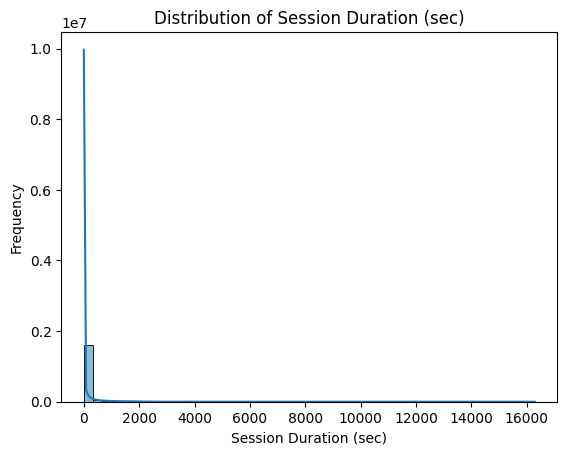

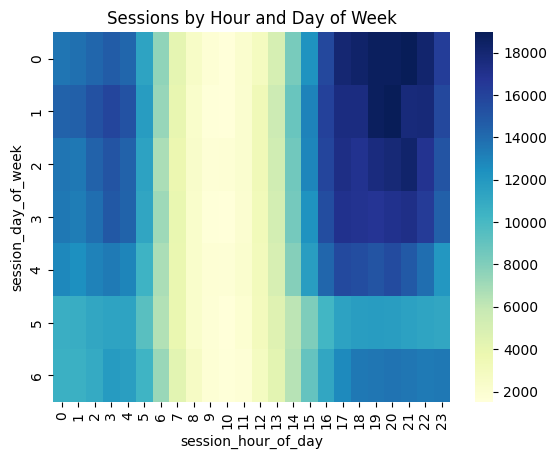

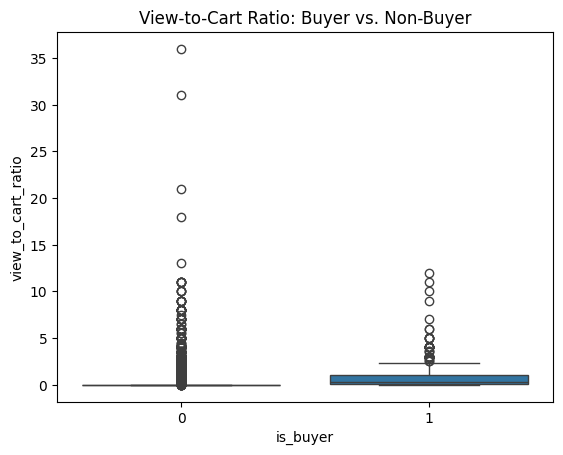

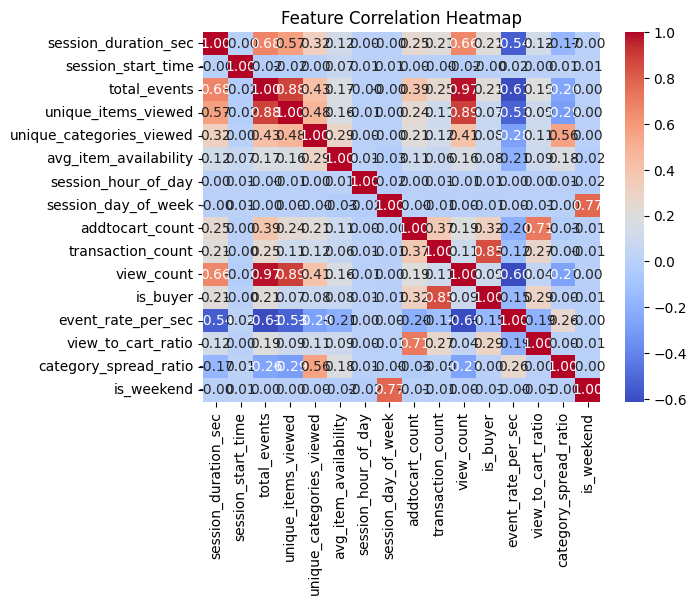

In [14]:
# 1. Session Duration Distribution
sns.histplot(session_feature_matrix['session_duration_sec'], bins=50, kde=True)
plt.title("Distribution of Session Duration (sec)")
plt.xlabel("Session Duration (sec)"); plt.ylabel("Frequency")
plt.show()

# 2. Session Start Time Heatmap
pd.crosstab(session_feature_matrix['session_day_of_week'], session_feature_matrix['session_hour_of_day']) \
  .pipe(lambda df: sns.heatmap(df, cmap="YlGnBu"))
plt.title("Sessions by Hour and Day of Week")
plt.show()

# 3. Buyer vs. Non-Buyer Boxplot
sns.boxplot(x="is_buyer", y="view_to_cart_ratio", data=session_feature_matrix)
plt.title("View-to-Cart Ratio: Buyer vs. Non-Buyer")
plt.show()

# 4. Correlation Heatmap
corr = session_feature_matrix.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


Loaded scaled feature matrix with shape: (1722864, 12)

Calculating WCSS (inertia) for k=1 to 10...
  WCSS for k=1: 20674368.00
  WCSS for k=2: 16265267.87
  WCSS for k=3: 13917673.21
  WCSS for k=4: 11689221.74
  WCSS for k=5: 10443653.51
  WCSS for k=6: 9002977.15
  WCSS for k=7: 8108650.69
  WCSS for k=8: 7379637.51
  WCSS for k=9: 6915434.95
  WCSS for k=10: 6364510.28
Calculation complete.
Plotting the Elbow Curve...


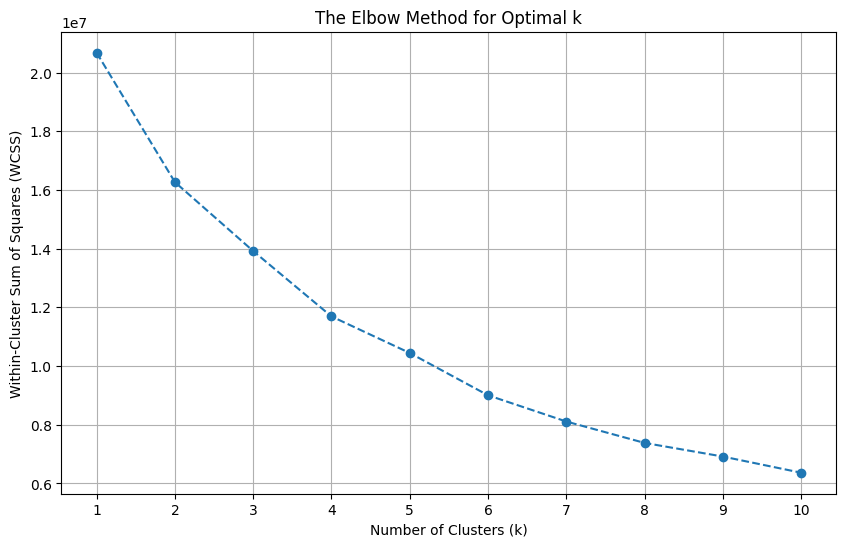

In [22]:
from sklearn.cluster import KMeans

# 1. Load the Scaled Data
# We must use the scaled data from (1. K-Means)
# is distance-based, so this ensures all features are weighted equally.
try:
    X_scaled_df = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_scaled.csv', index_col='session_id')
    print(f"Loaded scaled feature matrix with shape: {X_scaled_df.shape}")
except FileNotFoundError:
    print("Error: 'session_feature_matrix_scaled.csv' not found.")
    print("Please ensure you have run the feature engineering notebook first.")
    # In a notebook, you might 'raise' this error to stop execution
    X_scaled_df = None # Set to None to prevent further execution in this block

if X_scaled_df is not None:
    # 2. Calculate WCSS (Inertia) for a Range of k
    # REASONING: We will test a range of cluster counts (k) to find
    # the one with the best inertia score.
    wcss = []
    k_range = range(1, 11) # Test k from 1 to 10

    print("\nCalculating WCSS (inertia) for k=1 to 10...")

    for k in k_range:
        # We use 'k-means++' for smarter initial cluster center placement.
        # 'n_init=10' runs the algorithm 10 times with different centroids
        # and picks the best result, which helps avoid local optima.
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
        kmeans.fit(X_scaled_df)
        wcss.append(kmeans.inertia_)
        print(f"  WCSS for k={k}: {kmeans.inertia_:.2f}")

    print("Calculation complete.")

    # 3. Plot the Elbow Curve
    # REASONING: We now plot the results. The "elbow" point, where the
    # graph's slope changes from steep to shallow, is considered the
    # optimal k.
    print("Plotting the Elbow Curve...")
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, wcss, marker='o', linestyle='--')
    plt.title('The Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

Loaded scaled feature matrix with shape: (1722864, 12)
Created a random sample of 20000 sessions for silhouette analysis.

Calculating Silhouette Scores for k=2 to 10 (using sample)...
  Silhouette Score for k=2: 0.4293
  Silhouette Score for k=3: 0.3852
  Silhouette Score for k=4: 0.4045
  Silhouette Score for k=5: 0.4211
  Silhouette Score for k=6: 0.3627
  Silhouette Score for k=7: 0.4156
  Silhouette Score for k=8: 0.4235
  Silhouette Score for k=9: 0.4528
  Silhouette Score for k=10: 0.4486
Calculation complete.
Plotting the Silhouette Scores...


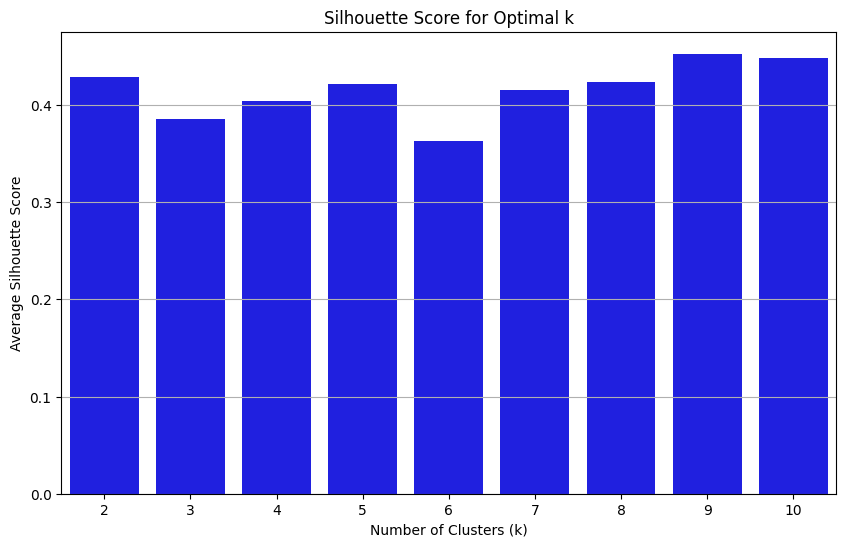

In [23]:
from sklearn.metrics import silhouette_score

try:
    X_scaled_df = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_scaled.csv', index_col='session_id')
    print(f"Loaded scaled feature matrix with shape: {X_scaled_df.shape}")
except FileNotFoundError:
    print("Error: 'session_feature_matrix_scaled.csv' not found.")
    X_scaled_df = None

if X_scaled_df is not None:
    # 2. Create a Data Sample
    # Reason: Calculating silhouette_score on 1.7M rows is too slow.
    # We will create a representative random sample to calculate the score.
    # 20,000 is a good, fast, and statistically relevant sample size.
    n_sample = 20000
    X_sample = X_scaled_df.sample(n=n_sample, random_state=42)
    print(f"Created a random sample of {n_sample} sessions for silhouette analysis.")

    # 3. Calculate Silhouette Scores for a Range of k
    # We will test k from 2 to 10. k=1 is not valid
    # for silhouette analysis as it cannot measure separation.
    silhouette_scores = []
    k_range = range(2, 11) # Test k from 2 to 10

    print("\nCalculating Silhouette Scores for k=2 to 10 (using sample)...")

    for k in k_range:
        # We fit the KMeans model on the *sample* for speed.
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)

        # Fit the model and get cluster labels for our sample
        labels = kmeans.fit_predict(X_sample)

        # Calculate the average silhouette score for this k
        score = silhouette_score(X_sample, labels)
        silhouette_scores.append(score)
        print(f"  Silhouette Score for k={k}: {score:.4f}")

    print("Calculation complete.")

    # 4. Plot the Silhouette Scores
    # We plot the results. Unlike the elbow, we are not
    # looking for a "bend." We are looking for the HIGHEST score.
    print("Plotting the Silhouette Scores...")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(k_range), y=silhouette_scores, color='blue')
    plt.title('Silhouette Score for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.xticks(range(len(k_range)), k_range) # Set labels to be 2, 3, 4...
    plt.grid(True, axis='y')
    plt.show()


In [27]:
# 1. Load the Scaled Data
try:
    X_scaled_df = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_scaled.csv', index_col='session_id')
    print(f"Loaded scaled feature matrix with shape: {X_scaled_df.shape}")
except FileNotFoundError:
    print("Error: 'session_feature_matrix_scaled.csv' not found.")
    X_scaled_df = None

# 2. Load the ORIGINAL (Unscaled) Data for Profiling
# We use the *scaled* data to TRAIN the model, but we must
# use the *original, unscaled* data to PROFILE the clusters (e.g.,
# "average duration is 300 seconds" is useful, "average duration is 0.5" is not).
try:
    # This assumes 'session_feature_matrix' is in memory from your previous notebook.
    # If not, you'll need to re-run cell 13 or load it from a saved file.
    # We are selecting the same features we used for scaling.
    features_for_clustering = [
        'session_duration_sec', 'total_events', 'unique_items_viewed',
        'unique_categories_viewed', 'avg_item_availability', 'session_hour_of_day',
        'view_count', 'addtocart_count', 'transaction_count', 'is_buyer',
        'event_rate_per_sec', 'view_to_cart_ratio', 'category_spread_ratio', 'is_weekend'
    ]
    # We add 'is_buyer' and 'transaction_count' back in for profiling.
    X_original_df = session_feature_matrix[features_for_clustering].copy()
    print(f"Loaded original (unscaled) feature matrix for profiling: {X_original_df.shape}")
except Exception as e:
    print(f"Error: Original 'session_feature_matrix' not found in memory. {e}")
    X_original_df = None

if X_scaled_df is not None and X_original_df is not None:

    # 3. Run K-Means with Optimal k=5
    k_optimal = 5

    print(f"\nRunning K-Means with k={k_optimal} on the full scaled dataset...")
    kmeans = KMeans(n_clusters=k_optimal, init='k-means++', n_init=10, random_state=42)

    # This step trains the model and assigns a cluster label to each session
    cluster_labels = kmeans.fit_predict(X_scaled_df)

    print("K-Means training complete.")

    # 4. Add Labels to Original Data for Profiling ---
    # REASONING: We add the new 'cluster' label to our original, unscaled
    # dataframe so we can understand the real-world meaning of each cluster.
    X_profile = X_original_df.copy()
    X_profile['cluster'] = cluster_labels

    print("Added cluster labels to original (unscaled) data.")

    # 5. Profile the Clusters
    # REASONING: We calculate the mean (average) of every feature
    # for each cluster. This is the core of cluster profiling.
    print("Calculating cluster profiles (mean values)...")
    cluster_profiles = X_profile.groupby('cluster').mean()

    # We should also get the size of each cluster
    cluster_size = X_profile['cluster'].value_counts().sort_index()
    cluster_profiles['cluster_size'] = cluster_size
    cluster_profiles['cluster_size_percent'] = (cluster_size / cluster_size.sum()) * 100

    print("\n--- K-MEANS CLUSTER PROFILES (k=5) ---")

    # Transpose (T) for easier reading in the console
    display(cluster_profiles.T)

    # Save the profiled data for analysis and for Milestone 2
    X_profile.to_csv(f'{BASE_DIR}/session_feature_matrix_with_clusters.csv')
    print("\nFull feature matrix with cluster labels saved to 'session_feature_matrix_with_clusters.csv'")

Loaded scaled feature matrix with shape: (1722864, 12)
Loaded original (unscaled) feature matrix for profiling: (1722864, 14)

Running K-Means with k=5 on the full scaled dataset...
K-Means training complete.
Added cluster labels to original (unscaled) data.
Calculating cluster profiles (mean values)...

--- K-MEANS CLUSTER PROFILES (k=5) ---


cluster,0,1,2,3,4
session_duration_sec,350.933378,0.014819,0.039055,15.427636,1525.836029
total_events,2.782448,1.006571,1.007253,1.076244,10.796173
unique_items_viewed,2.005151,1.002027,1.000676,1.018097,7.201369
unique_categories_viewed,1.158045,1.000816,1.000162,0.000000,2.381189
avg_item_availability,0.605196,0.999881,0.000046,0.000000,0.759773
session_hour_of_day,12.613971,12.797368,12.598211,12.629442,12.489554
view_count,2.649644,0.997385,1.006267,1.075633,9.814036
addtocart_count,0.102317,0.007655,0.000818,0.000330,0.793890
transaction_count,0.030487,0.001531,0.000168,0.000281,0.188246
is_buyer,0.027894,0.001133,0.000138,0.000173,0.096691



Full feature matrix with cluster labels saved to 'session_feature_matrix_with_clusters.csv'


## Clusters Visualizations

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


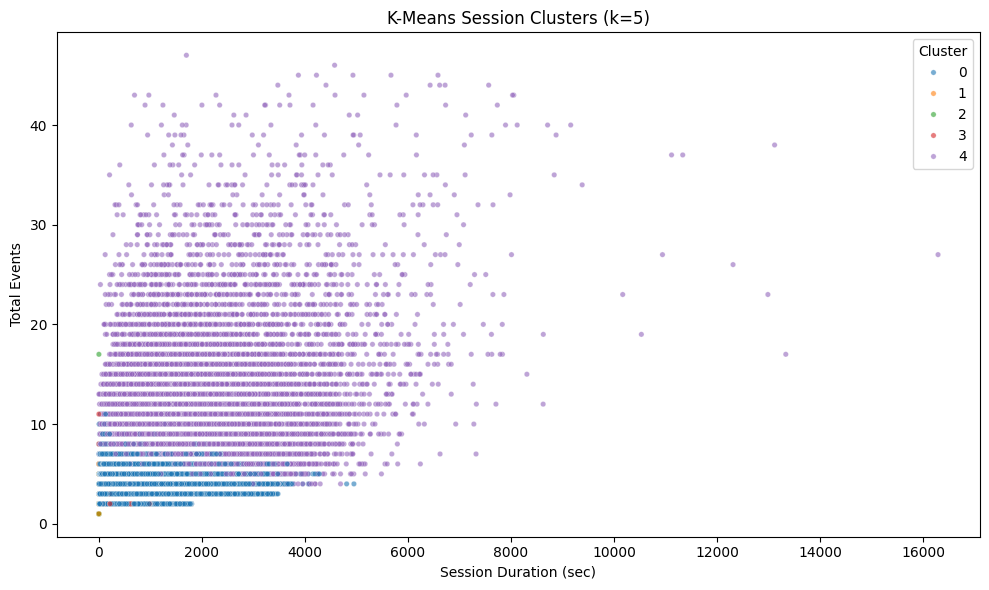

In [5]:
df = pd.read_csv('/content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/session_feature_matrix_with_clusters.csv', index_col='session_id')

# OPTIONAL: Use a sample for faster plotting if dataset is huge
# df = df.sample(n=5000, random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='session_duration_sec',
    y='total_events',
    hue='cluster',
    palette='tab10',  # up to 10 clusters
    alpha=0.6,
    s=15
)

plt.title('K-Means Session Clusters (k=5)')
plt.xlabel('Session Duration (sec)')
plt.ylabel('Total Events')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

<Axes: xlabel='log_session_duration', ylabel='total_events'>

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


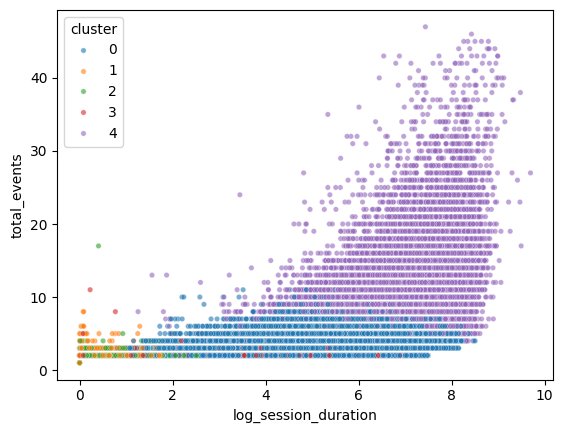

In [6]:
df['log_session_duration'] = (df['session_duration_sec'] + 1).apply(np.log)
sns.scatterplot(data=df, x='log_session_duration', y='total_events', hue='cluster', palette='tab10', alpha=0.6, s=15)

<Axes: xlabel='log_session_duration', ylabel='unique_items_viewed'>

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


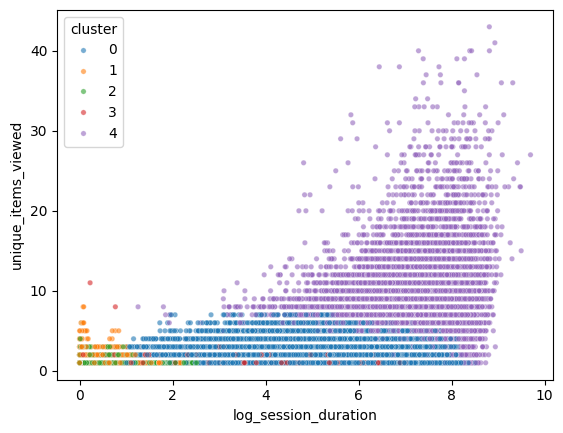

In [7]:
df['log_session_duration'] = (df['session_duration_sec'] + 1).apply(np.log)
sns.scatterplot(data=df, x='log_session_duration', y='unique_items_viewed', hue='cluster', palette='tab10', alpha=0.6, s=15)

<Axes: xlabel='log_session_duration', ylabel='event_rate_per_sec'>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


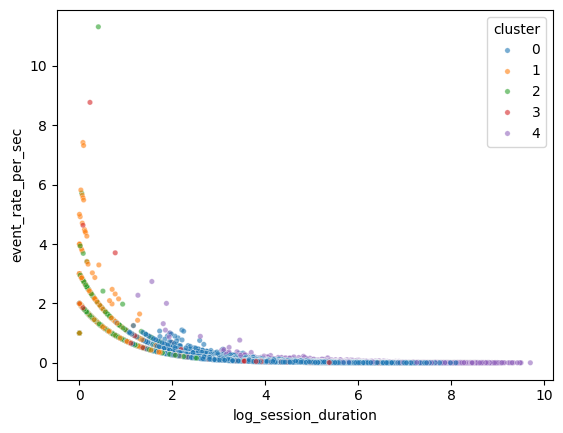

In [8]:
df['log_session_duration'] = (df['session_duration_sec'] + 1).apply(np.log)
sns.scatterplot(data=df, x='log_session_duration', y='event_rate_per_sec', hue='cluster', palette='tab10', alpha=0.6, s=15)

## Summary / notes

- Cluster 2: "The Out-of-Stock Bouncer" (41.2% of sessions)

  - This is the largest group of users. Their behavior is simple: they have one event (total_events: 1.0), zero duration (session_duration_sec: 0.04), and land on an item that is out of stock (avg_item_availability: 0.0).
  - They bounce immediately. This is a key insight for the e-commerce site.

- Cluster 1: "The In-Stock Bouncer" (27.3% of sessions)

  - This is the second-largest group and nearly identical to Cluster 2. They also have one event (total_events: 1.0) and zero duration (session_duration_sec: 0.01).
  - The only difference is they land on an item that is in stock (avg_item_availability: 1.0). They also bounce.

- Cluster 0: "The Window Shopper" (18.4% of sessions)

  - This is a more engaged browser. They have a medium-long session (session_duration_sec: 351s), but a very low event rate (event_rate_per_sec: 0.035), meaning they are slow and methodical.
  - They look at 2-3 items but have a low view_to_cart_ratio (0.06) and a very low buy rate (is_buyer: 2.8%).

- Cluster 3: "The Uncategorized Bouncer" (11.8% of sessions)

  - This is another "fly-by" group (1.07 events), but their defining feature is that they viewed items with no category (unique_categories_viewed: 0.0). This is a data quality segment.

- Cluster 4: "The Determined Buyer" (1.3% of sessions)

  - This is our most important cluster. It's the smallest group (1.3%) but by far the most valuable.

  - Behavior: They have the longest sessions (1526s, ~25 mins) and the most events (10.8).

  - Intent: They have the highest addtocart_count (0.79) and, critically, the highest view_to_cart_ratio (0.178).

  - Result: They have the highest purchase rate by a huge margin. 9.7% of sessions in this cluster result in a transaction, compared to <3% for all other groups.
